# Aestethic Visual Analysis (AVA): Data and image analysis

---



To train our model, we will use the AVA data set. It contains over 250,000 images taken by amateur photographers. Each image has a score between 1 and 10, semantic labels for over 60 categories and labels related to the challenge in which the images were submitted.



# Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Preprocesing

### Uncompressing file

In [2]:
# This step takes between 6 and 10 minutes
%time !tar xf /content/drive/My\ Drive/Meero/AVA_dataset/images.tar

CPU times: user 1.85 s, sys: 249 ms, total: 2.1 s
Wall time: 6min 36s


### Imports

In [0]:
import pandas as pd
from pathlib import Path
import glob
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [0]:
#Use the plotting package bokeh for interactive plots
from bokeh.plotting import figure, show, output_file
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper, ColorBar, BasicTicker
from bokeh.palettes import Category10_5, Category20_16, Inferno256
from bokeh.transform import transform

In [0]:
output_notebook()

### Paths

In [0]:
TAR_PATH = Path('/content/drive/My Drive/Meero/AVA_dataset/')
OUTPUT_PATH = Path('/content/drive/My Drive/Meero/output_files')
DATA_PATH = Path('/content/images/')

## Utils

In [0]:
def show_image(img_id, path = '/content/images/'):
  img = cv2.imread(path + str(img_id) + '.jpg')
  cv2_imshow(img)

## Dataset

In [0]:
def get_challenges_from_csv(csv_name: str = 'challenges.csv') -> dict:
  challenge_nump = pd.read_csv(TAR_PATH.joinpath(csv_name)).values
  challenge_dict = {}
  for id_challenge, value in challenge_nump:
    challenge_dict[id_challenge] = value
  return challenge_dict

In [0]:
df = pd.read_csv(OUTPUT_PATH.joinpath('AVA_with_notes.csv'))
df_dims = pd.read_csv(OUTPUT_PATH.joinpath('img_dims.csv'))
df_saliency = pd.read_csv(OUTPUT_PATH.joinpath('saliency.csv'))
df_luminance = pd.read_csv(OUTPUT_PATH.joinpath('luminance.csv'))
df_luminance = df_luminance[['idImage', 'luminance']]
df_colors = pd.read_csv(OUTPUT_PATH.joinpath('colors_split.csv'))
df_colors = df_colors[['idImage', 'B_mean', 'G_mean', 'R_mean']]
df_contrast = pd.read_csv(OUTPUT_PATH.joinpath('M_contrast.csv'))
df_contrast = df_contrast[['idImage', 'Michelson_contrast', 'RMS_contrast']]

df = df.merge(df_saliency, left_on = 'idImage' , right_on = 'img_ids')
df = df.merge(df_dims, left_on = 'idImage' , right_on = 'img_ids')
df = df.merge(df_colors, left_on = 'idImage' , right_on = 'idImage')
df = df.merge(df_contrast, left_on = 'idImage' , right_on = 'idImage')
columns = list(df.columns.values)
del columns[-10], columns[-8]
df = df[columns]

def get_resolution(x):
  return int(x[-6]) * int(x[-7])
df['resolution'] = df.apply(get_resolution, axis=1)

In [0]:
df.head()

idImage  count1  count2  ...  Michelson_contrast  RMS_contrast  resolution
0   953417       0       0  ...                 1.0     70.149474      545919
1   953777       0       3  ...                 1.0     53.167542      440000
2   953756       0       2  ...                 1.0     62.087104      475200
3   954195       0       1  ...                 1.0     43.769847      395638
4   953903       0       1  ...                 1.0     56.771740      426400

[5 rows x 25 columns]

In [0]:
challenge_dict = get_challenges_from_csv()

## Data cleaning

### Check if nan values are in the dataframe

In [0]:
df.isna().sum()

idImage               0
count1                0
count2                0
count3                0
count4                0
count5                0
count6                0
count7                0
count8                0
count9                0
count10               0
averaged_notes        0
nb_notes              0
semanticTag1          0
semanticTag2          0
idChallenge           0
saliency              0
height                0
width                 0
B_mean                0
G_mean                0
R_mean                0
Michelson_contrast    5
RMS_contrast          0
resolution            0
dtype: int64

There are not NaN values in the data set, which is good news !

There seems to be some images the csv file (our dataframe) that are not in the dataset. We thus delete them from our dataframe.

### Delete the rows corresponding to images which are not in the dataset

In [0]:
img_ids = df['idImage'].values

fake_ids = []
for img_id in img_ids:
  if not os.path.isfile(DATA_PATH.joinpath('{}.jpg'.format(img_id))):
    fake_ids.append(img_id)
print(len(fake_ids))
print(fake_ids)

0
[]


In [0]:
img_ids = df['idImage'].values

fake_ids = []
for img_id in img_ids:
  if not os.path.isfile(DATA_PATH.joinpath('{}.jpg'.format(img_id))):
    fake_ids.append(img_id)
print(len(fake_ids))

for fake_id in fake_ids:
  idx = df[df['idImage'] == fake_id].index.values[0]
  df.drop(index=idx, inplace=True)


0


## General data description

In [0]:
df[['count1', 'count2', 'count3', 'count4', 'count5', 'count6', 'count7', 'count8', 'count9', 'count10', 'averaged_notes', 'nb_notes', 'saliency', 'resolution']].describe()

count1         count2  ...       saliency     resolution
count  255508.000000  255508.000000  ...  255508.000000  255508.000000
mean        2.693442       5.702311  ...       0.215917  323022.217426
std         6.106174       7.505160  ...       0.073527   81276.857746
min         0.000000       0.000000  ...       0.000000   10800.000000
25%         0.000000       1.000000  ...       0.166553  273280.000000
50%         1.000000       3.000000  ...       0.215615  307200.000000
75%         3.000000       7.000000  ...       0.262976  360320.000000
max       238.000000      85.000000  ...       0.845730  640000.000000

[8 rows x 14 columns]

## Most and less liked images

### Most liked images

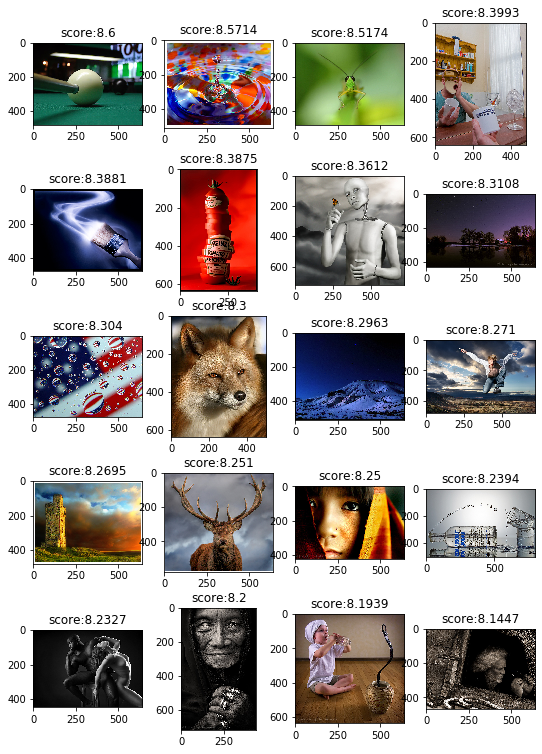

In [0]:
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

df_numpy = df.nlargest(20, 'averaged_notes', keep='all').values
ax = []

for i in range(columns*rows):
    img = Image.open(str(DATA_PATH.joinpath('{}.jpg'.format(int(df_numpy[i][0])))))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("score:"+str(round(df_numpy[i][11],4)))
    plt.imshow(img)

plt.show()

In [0]:
print('mean resolution on best grated images: {}'.format(df[df['averaged_notes'] > 8]['resolution'].mean()))
print('mean saliency on best grated images: {}'.format(df.nlargest(20, 'averaged_notes', keep='all')['saliency'].mean()))

mean resolution on best grated images: 328647.5681818182
mean saliency on best grated images: 0.19653503146348936


In [0]:
df[df['averaged_notes'] == df['averaged_notes'].max()]

idImage  count1  count2  count3  ...  saliency  height  width  resolution
223205      106       0       0       0  ...  0.245225     480    640      307200

[1 rows x 20 columns]

[[1.06000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.00000000e+00 5.00000000e+00 1.30000000e+01
  2.80000000e+01 2.90000000e+01 3.30000000e+01 8.60000000e+00
  1.10000000e+02 9.00000000e+00 2.20000000e+01 4.00000000e+00
  2.45224609e-01 4.80000000e+02 6.40000000e+02 3.07200000e+05]]


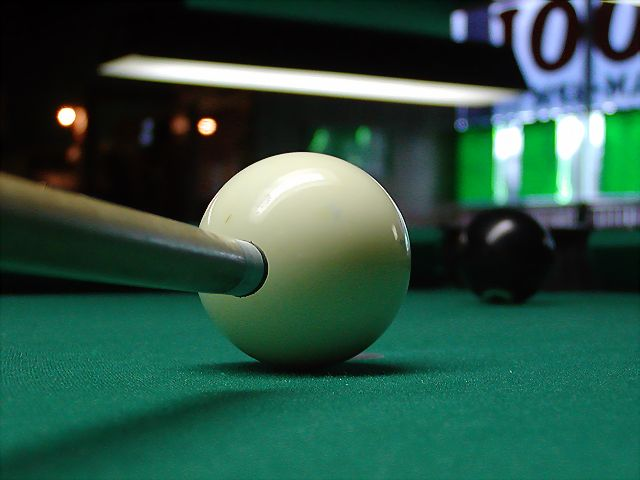

In [0]:
df_best = df[df['averaged_notes'] == df['averaged_notes'].max()]
print(df_best.values)
show_image(int(df_best['idImage']))

### Less liked images

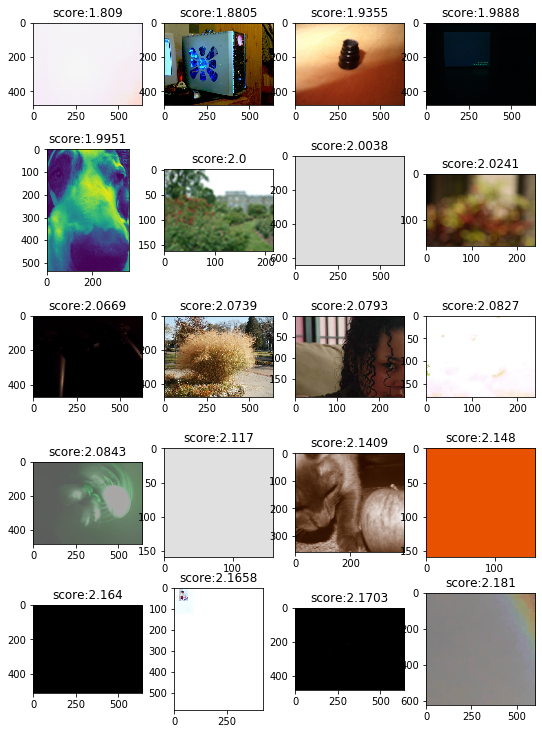

In [0]:
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

df_numpy = df.nsmallest(20, 'averaged_notes', keep='all').values
ax = []

for i in range(columns*rows):
    img = Image.open(str(DATA_PATH.joinpath('{}.jpg'.format(int(df_numpy[i][0])))))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("score:"+str(round(df_numpy[i][11],4)))
    plt.imshow(img)

plt.show()

In [0]:
print('mean resolution on worst grated images: {}'.format(df[df['averaged_notes'] < 3]['resolution'].mean()))
print('mean saliency on worst grated images: {}'.format(df.nsmallest(20, 'averaged_notes', keep='all')['saliency'].mean()))

mean resolution on worst grated images: 243945.80483271377
mean saliency on worst grated images: 0.11892020178541807


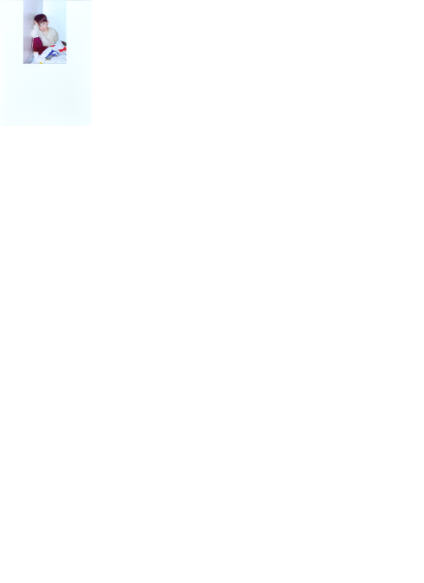

In [0]:
show_image(12966)

**The images with the lowest notes seems to be those which have a small resolution, which are blurried or those which are monochromatic.** 

##Image Size Distribution

In [0]:
sizeimages = pd.read_csv(os.path.join(OUTPUT_PATH, 'img_dims.csv'))
sizeimages.head()

img_ids  height  width
0   162781     463    640
1   674799     480    720
2   235935     635    385
3   622873     464    640
4   326231     613    640

In [0]:
p = figure(title = 'Image Sizes')
p.xaxis.axis_label = 'Image Height'
p.yaxis.axis_label = 'Image Width'

p.circle('height', 'width', size=2, source=sizeimages, alpha=0.1)

show(p)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
#Count Height images
sizeheights = sizeimages['height'].value_counts().to_frame()
sizeheights.reset_index(inplace=True)
sizeheights.rename(columns = {'index':'height','height':'height_count'}, inplace = True) 

In [0]:
#Count Width images
sizewidths = sizeimages['width'].value_counts().to_frame()
sizewidths.reset_index(inplace=True)
sizewidths.rename(columns = {'index':'width','width':'width_count'}, inplace = True) 

In [0]:
#Create the width & height histograms
TOOLTIPS = [
    ('Height (pixel): ', '@height'),
    ('Height Count: ', '@height_count')
]

#p1 : Width
p1 = figure(title = 'Histogram of Image Height',
          x_axis_label = 'Height', 
           y_axis_label = 'Count',
           tooltips=TOOLTIPS)

p1.vbar(top='height_count', 
       x='height', width=1.5, source=sizeheights)

#p2 : Height
p2 = figure(title = 'Histogram of Image Width',
          x_axis_label = 'Width', 
           y_axis_label = 'Count',
           tooltips=TOOLTIPS)

p2.vbar(top='width_count', 
       x='width', width=1.5, source=sizewidths)

# Show the plot
show(row(p1, p2))

print('There are', sizeheights.shape[0], 'different Height of Images')
print('There are', sizewidths.shape[0], 'different Width of Images')

There are 642 different Height of Images
There are 637 different Width of Images


In [0]:
#Count all combination width*height
sizeimagescount = sizeimages.drop(['img_ids'], axis=1).groupby(['height','width']).size().reset_index().rename(columns={0:'count'})
print(sizeimagescount)

       height  width  count
0          90    120      7
1         160    160      8
2         160    200      2
3         160    212      1
4         160    213     24
...       ...    ...    ...
25062     800    796     11
25063     800    797      7
25064     800    798     19
25065     800    799     18
25066     800    800   1049

[25067 rows x 3 columns]


In [0]:
TOOLTIPS = [
    ('Height (pixel): ', '@height'),
    ('Width (pixel): ', '@width'),
    ('Count', '@count')
]

sizeimagescount

#min max normalization
sizeimagescount['ncount'] = (sizeimagescount['count']-sizeimagescount['count'].min())/(sizeimagescount['count'].max()-sizeimagescount['count'].min()) * 100

color_mapper = LinearColorMapper(palette = Inferno256, low = sizeimagescount['ncount'].min(), high = sizeimagescount['ncount'].max())
color_bar = ColorBar(color_mapper = color_mapper,
                     location = (0, 0),
                     ticker = BasicTicker())
p = figure(title = 'Bubble Graph representing the Number of images per size',
           x_axis_label = 'Width', 
           y_axis_label = 'Height',
           tooltips=TOOLTIPS)
p.add_layout(color_bar, 'right')
p.scatter(x = 'width', y = 'height', size = 'ncount', legend = None, fill_color = transform('ncount', color_mapper), source = sizeimagescount)
show(p)

## Mean saliency visualisation

### High saliency

In [0]:
df.nlargest(1000, 'saliency', keep='all')['idChallenge'].value_counts()

606     14
444     14
317     13
910     12
529     10
        ..
359      1
758      1
1385     1
1388     1
1028     1
Name: idChallenge, Length: 516, dtype: int64

In [0]:
print(challenge_dict[910])

Abstract_Black_and_White


In [0]:
def int_averaged_note(x):
  return int(x)

df['averaged_notes_int'] = df['averaged_notes'].apply(lambda x: int_averaged_note(x))

In [0]:
df['averaged_notes_int'].value_counts()

5    131250
4     66076
6     46897
3      7444
7      3255
2       533
8        48
1         5
Name: averaged_notes_int, dtype: int64

In [0]:
(131250+ 66076 + 46897)/len(df)

0.9558330854611206

In [0]:
df[df['idChallenge'] == 910]

idImage  count1  count2  count3  ...  saliency  height  width  resolution
3693   714578       0       4       4  ...  0.171592     486    640      311040
3694   714320       2       3      12  ...  0.189502     640    640      409600
3695   713599       4      14      30  ...  0.310428     640    457      292480
3696   714549       2      12      18  ...  0.255607     640    452      289280
3697   714475       6       3      12  ...  0.217714     640    531      339840
...       ...     ...     ...     ...  ...       ...     ...    ...         ...
3999   712792       0       3       9  ...  0.144586     428    640      273920
4000   714575       0       3      11  ...  0.274601     427    640      273280
4001   713554       1       2       9  ...  0.478931     440    640      281600
4002   714210       0       2       5  ...  0.355396     640    503      321920
4003   713995       6       7      18  ...  0.216702     425    640      272000

[311 rows x 20 columns]

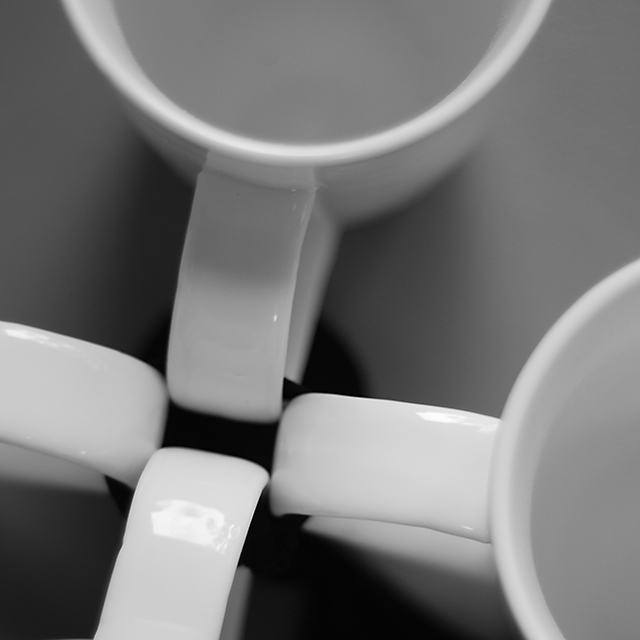

In [0]:
show_image(714320)

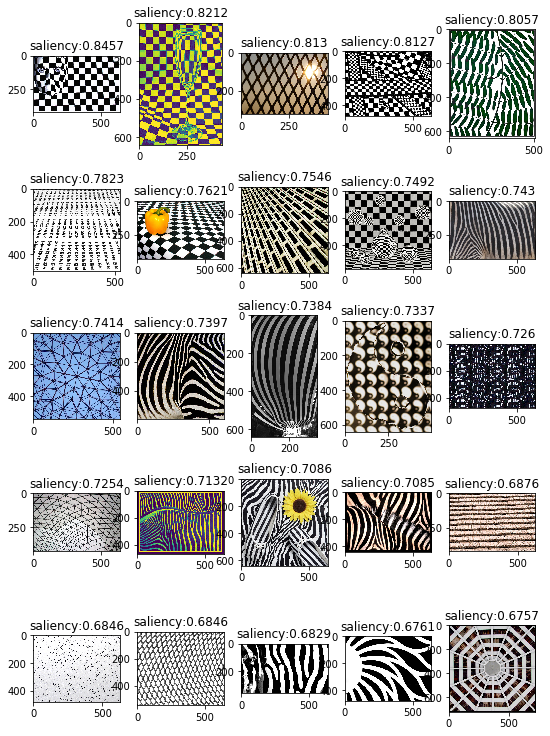

In [0]:
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

df_numpy = df.nlargest(20, 'saliency', keep='all').values
ax = []

for i in range(columns*rows):
    img = Image.open(str(DATA_PATH.joinpath('{}.jpg'.format(int(df_numpy[i][0])))))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("saliency:"+str(round(df_numpy[i][16],4)))
    plt.imshow(img)

plt.show()

**Images with high saliency: most of the time images in black and white with** 

### Low saliency

In [0]:
df.nsmallest(50, 'saliency', keep='all')

idImage  count1  count2  count3  ...  saliency  height  width  resolution
7960     304108     136      37      30  ...  0.000000     160    241       38560
7981     302318     112      42      24  ...  0.000000     512    640      327680
55596    184012     134      25      33  ...  0.000000     640    640      409600
59102    664551      27       6      19  ...  0.000000     720    720      518400
59191    664552      24      10      13  ...  0.000000     428    640      273920
67403    337511      63      20      27  ...  0.000000     480    640      307200
70446    659334     108      19       9  ...  0.000000     160    160       25600
97537    917467      85      10      14  ...  0.000000     160    160       25600
113344   657714      79      16      16  ...  0.000000     160    160       25600
115447   770432     238      36      50  ...  0.000000     720    482      347040
122196   386696      46      32      23  ...  0.000000     425    640      272000
129604   173434     207      46      35  ...  0.000000     445    640      284800
129713   173745     218      47      34  ...  0.000000     512    640      327680
151417   660808      96      21      14  ...  0.000000     160    160       25600
184733   897297      90      29      27  ...  0.000000     500    800      400000
185013   477472      89      25      14  ...  0.000000     640    640      409600
213617   506212     125      16      18  ...  0.000000     160    160       25600
224232   104023     195      16       4  ...  0.000000     640    640      409600
229889    33761      58      19      14  ...  0.000013     480    640      307200
155552   955001      27      11      12  ...  0.000014     800    800      640000
200904     2449     151      20      19  ...  0.000020     480    640      307200
154505    33310      71      23      11  ...  0.000033     480    640      307200
28468    738145       5      14      23  ...  0.001541     428    640      273920
176459   695641      23      16      24  ...  0.001576     720    720      518400
154983   938738       2       8      12  ...  0.002074     575    800      460000
248989   285060       7      17      52  ...  0.002686     427    640      273280
39875    584740       8       9      30  ...  0.002831     425    640      272000
195937   520119       7       5      25  ...  0.003001     640    427      273280
246292   941843       0       2      10  ...  0.003453     534    800      427200
135520   155772       5      10      29  ...  0.003520     640    621      397440
124012   497921       0       2       8  ...  0.003771     426    640      272640
161910    94809       4      24      53  ...  0.004167     480    640      307200
147109   901101       0       4       7  ...  0.004380     536    800      428800
254691   372500      18      19      38  ...  0.004596     450    600      270000
146506   171103       3       6      31  ...  0.004616     413    640      264320
209045   909235       1       4       7  ...  0.004687     523    800      418400
154650   540005       2       5      12  ...  0.004807     508    640      325120
241073     1544      27      38      47  ...  0.004928     480    640      307200
159455   111396      12      26      53  ...  0.005081     426    639      272214
55829     81747       2       1      12  ...  0.005149     427    640      273280
116138   772408       1       3      20  ...  0.005188     720    540      388800
87338    708681       0       1       5  ...  0.005203     720    500      360000
221846   907740       3       4       7  ...  0.005540     599    800      479200
154388     5786       4       9      24  ...  0.005713     480    640      307200
146807   458725       0       0       5  ...  0.005786     482    720      347040
132592   140921      16      28      56  ...  0.005944     324    432      139968
138429   309719     126      23      24  ...  0.006064     480    640      307200
64191    762367       7      19      31  ...  0.006437     427    640   

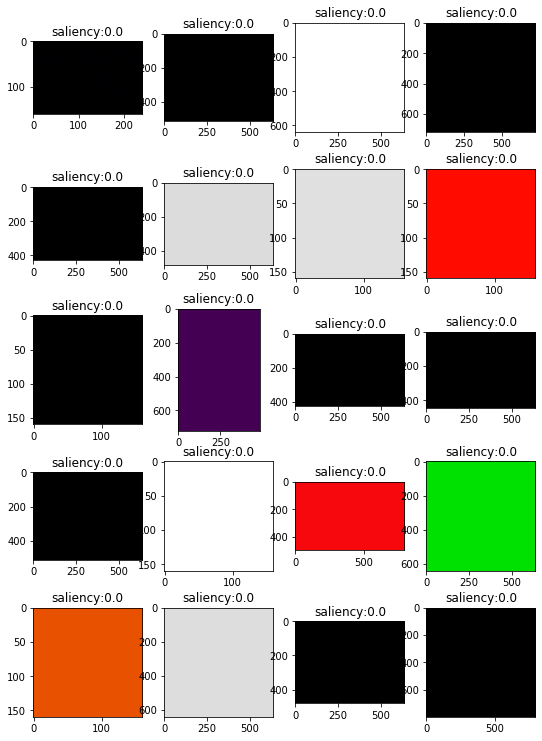

In [0]:
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

df_numpy = df.nsmallest(20, 'saliency', keep='all').values
ax = []

for i in range(columns*rows):
    img = Image.open(str(DATA_PATH.joinpath('{}.jpg'.format(int(df_numpy[i][0])))))
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("saliency:"+str(round(df_numpy[i][16],4)))
    plt.imshow(img)

plt.show()

**Images with low saliency are most of the time monochromatic images. There is a lot of chances that this pictures are conrrupted (problems during the creation of the dataset or maybe wrong images were upload by the users) as they don't match with their challenge labels. We could easily deleted them thanks to the saliency information** 

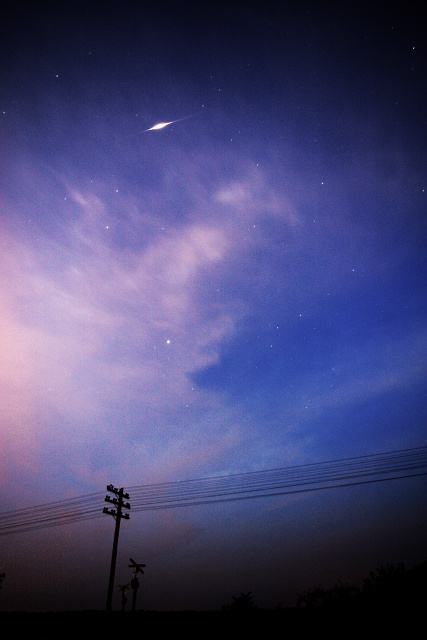

In [0]:
df[df['idImage'] ==520119]
show_image(520119)

**An example of non corrupted low saliency image.** 

### Grayscale and color distribution

In [0]:
df_gray=pd.read_csv(OUTPUT_PATH.joinpath('luminance.csv'))
df_color=pd.read_csv(OUTPUT_PATH.joinpath('colors_split.csv'))

#### Grayscale histogram
If we convert the image from the RGB colorspace to grayscale, we can get a value for each pixel between 0 and 255 that shows the luminance of the image.
If we plot an histogram of this grayscale, the X-axis represents the possible values of luminance (0-255) and the Y-axis counts the number of pixels in each bin. The right part of the histogram represents the "white" pixels in the image, and the left part represent the "black" pixels of and image. We can see an example for a single image.

#### Code

In [0]:
df_l_and_c = df[['idImage']]

In [0]:
def get_luminance_and_contrast(idx):
  fn = str(DATA_PATH.joinpath('{}.jpg'.format(idx)))
  img = cv2.imread(fn)
  luminance = (0.27 * img[:,:,0] + 0.67 * img[:,:,1] + 0.06 * img[:,:,2])
  l_mean = luminance.mean()/255
  l_max = luminance.max()
  l_min = luminance.min()
  contrast = (l_max - l_min) / (l_max + l_min)
  return l_mean, contrast

In [0]:
df_l_and_c['luminance_and_contrast'] = df_l_and_c['idImage'].apply(get_luminance_and_contrast)

In [0]:
df_l_and_c.head()

In [0]:
df_l_and_c.to_csv(OUTPUT_PATH.joinpath('luminance_and_contrast.csv'), index = False)

In [0]:
def get_luminance(idx):
  fn = str(DATA_PATH.joinpath('{}.jpg'.format(idx)))
  img = cv2.imread(fn)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  luminance=np.mean(gray)
  return luminance

In [0]:
def get_luminance_hist(idx):
  fn = str(DATA_PATH.joinpath('{}.jpg'.format(idx)))
  img = cv2.imread(fn)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
  plt.figure()
  plt.title("Grayscale Histogram")
  plt.xlabel("Bins")
  plt.ylabel("# of Pixels")
  plt.plot(hist)
  plt.xlim([0, 256])

#### Example
For the image shown below, we first converted it to a grayscale image and then we have plotted the grayscale histogram : the bins (0-255) are plotted on the X-axis. The Y-axis counts the number of pixels in each bin. The majority of pixels fall in the range of ~0 to ~25. This means that there are many "dark" pixels. There is also a peak at ~80, showing a presence of brighter pixels but that still remain dark. Looking at the right tail of the histogram, we see very few pixels in the range 100 to 255. This means that there are very few “white” pixels in the image.

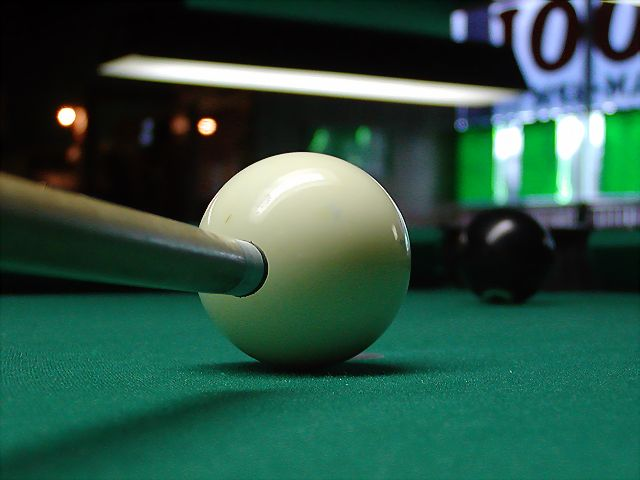

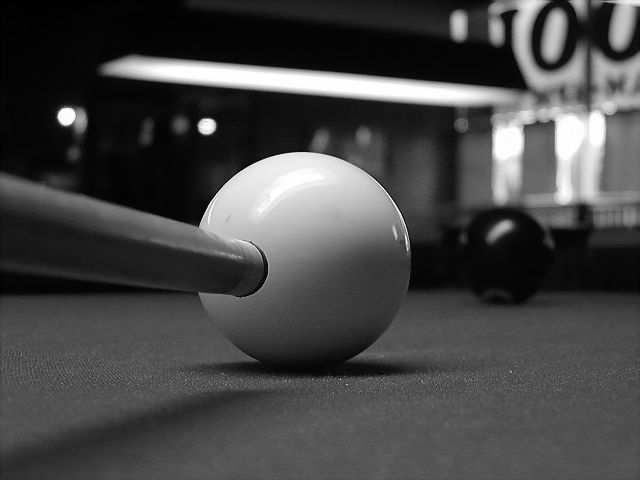

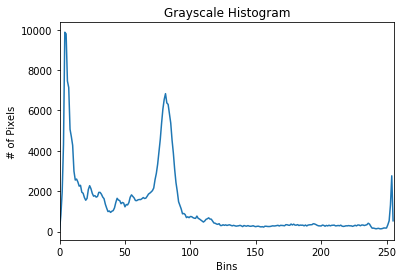

In [0]:
image=cv2.imread(str(DATA_PATH.joinpath('{}.jpg'.format(106))))
show_image(106)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
get_luminance_hist(106)

To get a sense of the grayscale of all the data set, we calculated the mean luminance of all images and plotted the histogram that you can find below. <br>
It shows that most of the images have a mean luminance of ~100, which means that in average most of the images have a medium luminance.

Text(0.5, 1.0, 'Grayscale Histogram of all the data set')

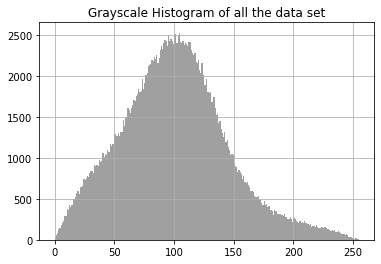

In [0]:
df_gray['luminance'].hist(bins=255,alpha=0.75,color='gray')
plt.title('Grayscale Histogram of all the data set')

### Luminance correlation
Here, we can see that the correlation between the mean luminance and the average score is not very high. It might be more relevant to look at the correlation between the extreme values and the standard deviance of the luminance and the mean score.

In [0]:
df_gray[['averaged_notes','luminance']].corr()

averaged_notes  luminance
averaged_notes        1.000000  -0.033163
luminance            -0.033163   1.000000

#### Color histogram

Now, we can analyse the 3 color channels in the images : Blue, Green and Red. As before, the right part of the histogram represents the "brighter" pixels in the image, and the left part represent the "darker" pixels of and image. We can see an example for the previous image.

#### Code

In [0]:
def get_colors_hist(idx):
  fn = str(DATA_PATH.joinpath('{}.jpg'.format(idx)))
  img = cv2.imread(fn)
  chans = cv2.split(img)
  colors = ("b", "g", "r")
  plt.figure()
  plt.title("'Flattened' Color Histogram")
  plt.xlabel("Bins")
  plt.ylabel("# of Pixels")
  features = []
 
  # loop over the image channels
  for (chan, color) in zip(chans, colors):
	  # create a histogram for the current channel and
	  # concatenate the resulting histograms for each
	  # channel
	  hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	  features.extend(hist)
 
	  # plot the histogram
	  plt.plot(hist, color = color)
	  plt.xlim([0, 256])

#### Example
We plotted the color histogram of the previous : the bins (0-255) are plotted on the X-axis. The Y-axis counts the number of pixels in each bin, for each channel (blue,green and red). He can see that there is a strong presence of dark reds, and the green and blue pixels are of medium "intensity". There are few "bright" color pixels, and this is coherent with the fact that this image is pretty dark as we saw before.

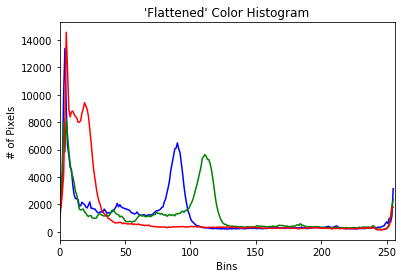

In [0]:
get_colors_hist(106)

As before, to get a sense of the color scale of all the data set, we calculated the mean colorscale of all images and for each channel, then plotted the histogram that you can find below. <br>
It shows that most of the images have a mean colorscale of ~100 for the green and red channel, which means that in average most of the images have a medium "strength" for those channels. The blue channel is a bit darker. We will see further if the colorscale of each channel has an influence on the score of the image.

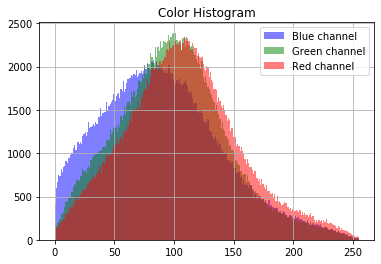

In [0]:
df_color['B_mean'].hist(bins=255,alpha=0.5,color='blue',label='Blue channel')
df_color['G_mean'].hist(bins=255,alpha=0.5,color='green',label='Green channel')
df_color['R_mean'].hist(bins=255,alpha=0.5,color='red',label='Red channel')
plt.title('Color Histogram')
plt.legend()

### Color correlation
Similarly to the luminance, we can see that the correlation between the mean color intensity for all the three chanels (blue, green and red) and the average score is not very high. It might be more relevant to look at the correlation between the extreme values and the standard deviance of the luminance and the mean score.

In [0]:
df_color[['averaged_notes','B_mean','G_mean','R_mean']].corr()

averaged_notes    B_mean    G_mean    R_mean
averaged_notes        1.000000 -0.020755 -0.030155 -0.038646
B_mean               -0.020755  1.000000  0.865104  0.668825
G_mean               -0.030155  0.865104  1.000000  0.859739
R_mean               -0.038646  0.668825  0.859739  1.000000

## Semantic tag distribution

#### Code

In [0]:
def get_sem_tags_from_csv(csv_name: str = 'tags.csv') -> dict:
  tags_nump = pd.read_csv(TAR_PATH.joinpath(csv_name)).values
  tags_dict = {}
  for id_tag, value in tags_nump:
    tags_dict[id_tag] = value
  return tags_dict

In [0]:
tags_dict = get_sem_tags_from_csv()
df_tags=pd.DataFrame.from_dict(tags_dict,orient='index')

In [0]:
tag_count=df.groupby('semanticTag2').count()['averaged_notes']
tag_count=df.groupby('semanticTag1').count()['averaged_notes']

tags_count=pd.DataFrame(tag_count.add(tag_count, fill_value=0))
tags_count['idSemantic']=tags_count.index

tags_count=tags_count.merge(df_tags,left_on='idSemantic',right_on=df_tags.index)
tags_count.columns=['averaged_notes','idSemantic','tagNameSemantic']
tags_count.sort_values('averaged_notes')

averaged_notes  idSemantic    tagNameSemantic
54               4          55           Overlays
53               6          54     TextureLibrary
55               8          56          Maternity
64              16          65        Insects-etc
59              18          60  Pinhole-ZonePlate
..             ...         ...                ...
16           22276          17        Portraiture
17           27686          18          StillLife
0            35696           1           Abstract
13           37676          14          Landscape
14           41648          15             Nature

[65 rows x 3 columns]

In [0]:
def interactive_hist_count(df,tagNameCol,idSem,weights,title,x_axis_label,x_tooltip):
    """Plot interactive histogram using bokeh.
    
    df: pandas dataframe
    tagNameCol: column of panda dataframe to plot 
    n_bins: number of bins, 
    bin_range: list with min and max value. 
    title: title of plot. 
    x_axis_label: x axis label. 
    x_tooltip: x axis tooltip string.
    
    """
    arr_hist, edges = np.histogram(df[idSem],weights=df[weights],bins=df.shape[0],range=[0,df.shape[0]])

    # Column data source
    arr_df = pd.DataFrame({'count': df.sort_values(weights)[weights], 'idSemantic': df.sort_values(weights)[idSem], 'tagNameSemantic': df.sort_values(weights)[tagNameCol],'left': edges[:-1], 'right': edges[1:]})
    arr_df['f_count'] = ['%d' % count for count in arr_df['count']]
    arr_df['f_tag'] = ['%s' % tag for tag in arr_df['tagNameSemantic']]
    arr_df['f_id'] = ['%d' % tag for tag in arr_df['idSemantic']]
    arr_df['f_interval'] = ['%d to %d ' % (left, right) for left, right in zip(arr_df['left'], arr_df['right'])]


    # column data source
    arr_src = ColumnDataSource(arr_df)

    # Set up the figure same as before
    p = figure(plot_width = 500, 
               plot_height = 500,
               title = title,
               x_axis_label = x_axis_label, 
               y_axis_label = 'Count')

    # Add a quad glyph with source this time
    p.quad(bottom=0, 
           top='count', 
           left='left', 
           right='right', 
           source=arr_src,
           fill_color='blue',
           hover_fill_alpha=0.7,
           hover_fill_color='red',
           line_color='black')

    # Add style to the plot
    p.title.align = 'center'
    p.title.text_font_size = '18pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Add a hover tool referring to the formatted columns
    hover = HoverTool(tooltips = [(x_tooltip, '@f_interval'),
                                  ('Semantic Name', '@f_tag'),
                                  ('Count', '@f_count')])

    # Add the hover tool to the graph
    p.add_tools(hover)

    return p

In [0]:
def interactive_hist_mean(df,tagNameCol,idSem,weights,title,x_axis_label,x_tooltip):
    """Plot interactive histogram using bokeh.
    
    df: pandas dataframe
    col: column of panda dataframe to plot 
    n_bins: number of bins, 
    bin_range: list with min and max value. 
    title: title of plot. 
    x_axis_label: x axis label. 
    x_tooltip: x axis tooltip string. 
    
    """
    arr_hist, edges = np.histogram(df[idSem],weights=df[weights],bins=df.shape[0],range=[0,df.shape[0]])

    # Column data source
    arr_df = pd.DataFrame({'count': df.sort_values(weights)[weights], 'idSemantic': df.sort_values(weights)[idSem], 'tagNameSemantic': df.sort_values(weights)[tagNameCol],'left': edges[:-1], 'right': edges[1:]})
    arr_df['f_count'] = ['%f' % count for count in arr_df['count']]
    arr_df['f_tag'] = ['%s' % tag for tag in arr_df['tagNameSemantic']]
    arr_df['f_id'] = ['%d' % tag for tag in arr_df['idSemantic']]
    arr_df['f_interval'] = ['%d to %d ' % (left, right) for left, right in zip(arr_df['left'], arr_df['right'])]


    # column data source
    arr_src = ColumnDataSource(arr_df)

    # Set up the figure same as before
    p = figure(plot_width = 500, 
               plot_height = 500,
               title = title,
               x_axis_label = x_axis_label, 
               y_axis_label = 'Count')

    # Add a quad glyph with source this time
    p.quad(bottom=0, 
           top='count', 
           left='left', 
           right='right', 
           source=arr_src,
           fill_color='blue',
           hover_fill_alpha=0.7,
           hover_fill_color='red',
           line_color='black')

    # Add style to the plot
    p.title.align = 'center'
    p.title.text_font_size = '18pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Add a hover tool referring to the formatted columns
    hover = HoverTool(tooltips = [(x_tooltip, '@f_interval'),
                                  ('Semantic Name', '@f_tag'),
                                  ('Mean', '@f_count')])

    # Add the hover tool to the graph
    p.add_tools(hover)

    return p

### General distribution of the semantic tags

The AVA dataset contains to features called "semantic tags". They correspond to the overall theme of the pictures. <br>
Here we can see the distribution of the images according to these tags. For example, most of images are "Nature" or "Black and white" pictures, whereas there are not many pictures of "Fish-Eye" or "Maternity".

In [0]:
# To show in notebook
output_notebook()

# Show the plot
tagCol='tagNameSemantic'
weight = 'averaged_notes'
idSem='idSemantic'
title = 'Semantic tags distribution'
x_axis_label = 'Tag (id)'
x_tooltip = 'Semantic tag'
bp = interactive_hist_count(tags_count,tagCol,idSem,weight,title,x_axis_label,x_tooltip)
show(bp)

### Correlation Between the number of notes and the semantic Tags

In [0]:
avanotes = pd.read_csv(os.path.join(OUTPUT_PATH, 'AVA_with_notes.csv'))
avanotes_desc = avanotes.describe()

In [0]:
cols = ['count1', 'count2', 'count3', 'count4', 'count5', 'count6', 'count7', 'count8', 'count9', 'count10']
custom_desc = pd.DataFrame()
custom_desc['count'] = avanotes[cols].sum(axis = 0)
custom_desc['mean'] = avanotes_desc.loc['mean', cols]
custom_desc['std'] = avanotes_desc.loc['std', cols]
custom_desc['q1'] = avanotes_desc.loc['25%', cols]
custom_desc['q2'] = avanotes_desc.loc['50%', cols]
custom_desc['q3'] = avanotes_desc.loc['75%', cols]
custom_desc['min'] = avanotes_desc.loc['min', cols]
custom_desc['max'] = avanotes_desc.loc['max', cols]
custom_desc.reset_index(inplace=True)

In [0]:
TOOLTIPS = [
    ('Note: ', '@index'),
    ('Count: ', '@count'),
    ('Mean: ', '@mean'),
    ('Standard Deviation: ', '@std'),
    ('First Quartile: ', '@q1'), 
    ('Second Quartile: ', '@q2'),
    ('Third Quartile: ', '@q3'),
    ('Min: ', '@min'),
    ('Max: ', '@max')
]
cats = list(cols)

p = figure(title='Box Plot count of notes for each grade', tooltips=TOOLTIPS, background_fill_color="#efefef", x_range=cats)

# stems
p.segment(x0='index', y0='max', x1='index', y1='q3', line_color="black", source=custom_desc)
p.segment(x0='index', y0='min', x1='index', y1='q1', line_color="black", source=custom_desc)

# boxes
p.vbar(x='index', width=0.7, top='q2', bottom='q3', fill_color="#E08E79", line_color="black", source=custom_desc)
p.vbar(x='index', width=0.7, top='q1', bottom='q2', fill_color="#3B8686", line_color="black", source=custom_desc)

# whiskers 
p.rect(x='index', y='min', width=0.2, height=0.01, line_color="black", source=custom_desc)
p.rect(x='index', y='max', width=0.2, height=0.01, line_color="black", source=custom_desc)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="12pt"

show(p)

In [0]:
nb_notes_stats = avanotes[['nb_notes', 'semanticTag1', 'semanticTag2']].groupby(['semanticTag1','semanticTag2']).sum()
nb_notes_stats.reset_index(inplace=True)
nb_notes_stats.drop(nb_notes_stats.index[0], inplace=True)
nb_notes_stats.sort_values('nb_notes')

semanticTag1  semanticTag2  nb_notes
1571            41            54       103
1326            29            61       108
447              8            62       113
1683            52            53       116
1046            21            55       122
...            ...           ...       ...
690             14             0    726505
744             15            22    732919
926             19             0    803264
692             14            15   1044017
741             15            19   1141601

[1717 rows x 3 columns]

In [0]:
TOOLTIPS = [
    ('ID Semantic Tag 1: ', '@semanticTag1'),
    ('ID Semantic Tag 2: ', '@semanticTag2'),
    ('Number of Notes: ', '@nb_notes')
]

nb_notes_stats

#min max normalization
nb_notes_stats['ncount'] = (nb_notes_stats['nb_notes']-nb_notes_stats['nb_notes'].min())/(nb_notes_stats['nb_notes'].max()-nb_notes_stats['nb_notes'].min()) * 100

color_mapper = LinearColorMapper(palette = Inferno256, low = nb_notes_stats['ncount'].min(), high = nb_notes_stats['ncount'].max())
color_bar = ColorBar(color_mapper = color_mapper,
                     location = (0, 0),
                     ticker = BasicTicker())
p = figure(title = 'Bubble Graph representing the Number of Notes relative to the Semantic tags',
           x_axis_label = 'semanticTag1', 
           y_axis_label = 'HeisemanticTag2',
           tooltips=TOOLTIPS)
p.add_layout(color_bar, 'right')
p.scatter(x = 'semanticTag1', y = 'semanticTag2', size = 'ncount', legend = None, fill_color = transform('ncount', color_mapper), source = nb_notes_stats)
show(p)
nb_notes_stats.drop('ncount', axis=1, inplace=True)

In [0]:
dftemp = pd.DataFrame()
dftemp[['semanticTag1', 'nb_notes']] = nb_notes_stats[['semanticTag2', 'nb_notes']]
nb_notes_stats2 = nb_notes_stats.drop('semanticTag2', axis=1)
nb_notes_stats2 = pd.concat([nb_notes_stats2, dftemp], ignore_index=True)
nb_notes_stats2.groupby(['semanticTag1']).sum()
nb_notes_stats2.sort_values('nb_notes')

semanticTag1  nb_notes
1570            41       103
3287            54       103
3042            61       108
1325            29       108
2163            62       113
...            ...       ...
925             19    803264
691             14   1044017
2408            15   1044017
2457            19   1141601
740             15   1141601

[3434 rows x 2 columns]

### Average score per semantic tag

#### Code

In [0]:
tag1_mean=df.groupby('semanticTag2').mean()['averaged_notes']
tag2_mean=df.groupby('semanticTag1').mean()['averaged_notes']

tags_mean=(tag1_mean+tag2_mean)/2
tags_mean.iloc[1]=tag1_mean.iloc[1]
tags_mean=pd.DataFrame(tags_mean)
tags_mean['idSemantic']=tags_mean.index

tags_mean=tags_mean.merge(df_tags,left_on='idSemantic',right_on=df_tags.index)
tags_mean.columns=['averaged_notes','idSemantic','tagNameSemantic']
tags_mean.sort_values('averaged_notes')
tags_mean

averaged_notes  idSemantic tagNameSemantic
0         5.215628           1        Abstract
1         5.346911           2       Cityscape
2         5.270287           3         Fashion
3         5.122383           4          Family
4         5.165785           5        Humorous
..             ...         ...             ...
60        5.421352          61          Street
61        5.268327          62        Lensbaby
62        5.616752          63         FishEye
63        5.628078          64    CameraPhones
64        5.664075          65     Insects-etc

[65 rows x 3 columns]

#### Average score by semantic tag
We also grouped the images by semantic tag, to see overall theme had an influence on the score. In this graph, we can see that grouped by semantic tag, the images have an average score between 5 and 6. This means that this tag doesn't really influence on the average score.

In [0]:
# To show in notebook
output_notebook()

# Show the plot
df_hist_mean = tags_mean
title = 'Average scores by semantic tags'

bp = interactive_hist_mean(df_hist_mean,tagCol,idSem,weight,title,x_axis_label,x_tooltip)
show(bp)

## Correlation between the variables

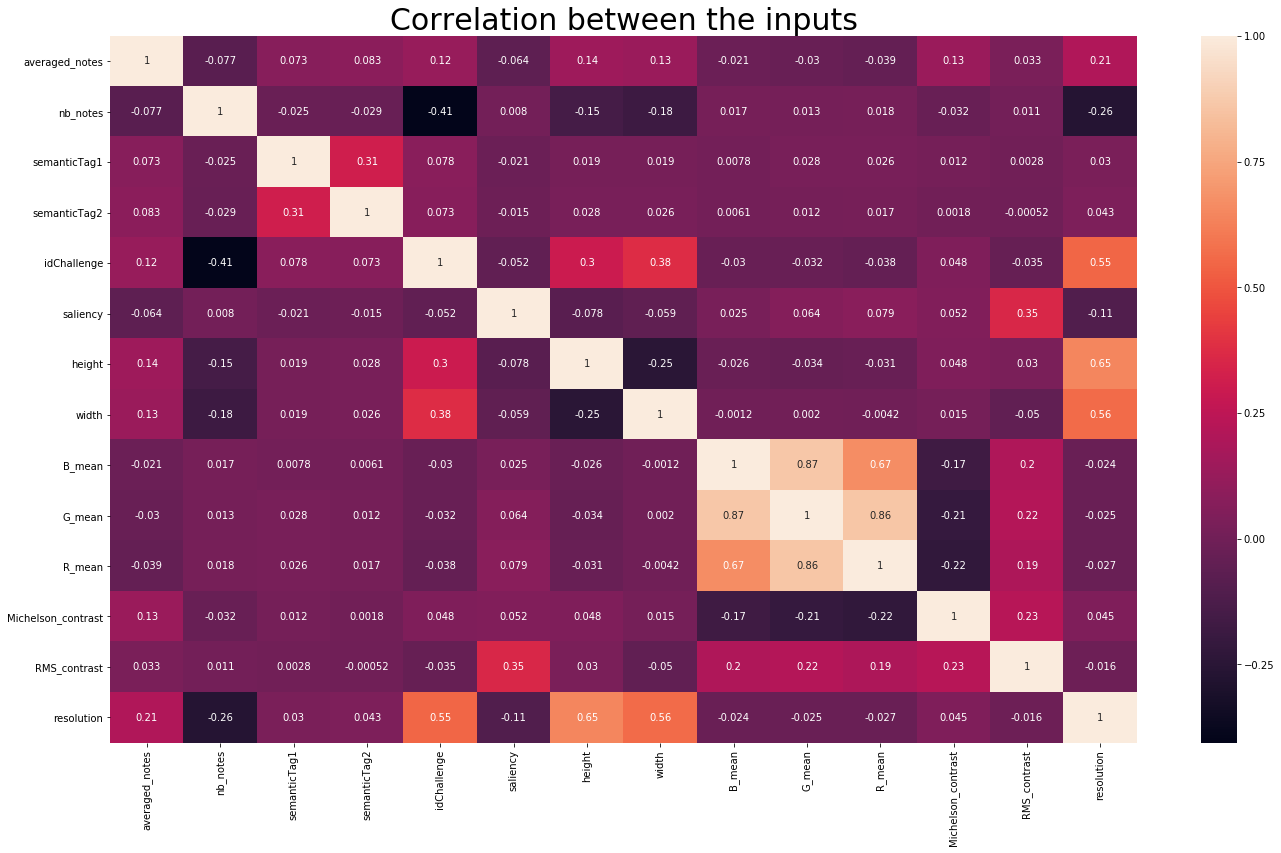

In [0]:
corr=df[df.columns[11:]].corr()
plt.rcParams['figure.figsize'] = (23, 13)
sns.heatmap(corr, annot = True)
plt.title('Correlation between the inputs', fontsize = 30)
plt.show()

idchallenge inversement corrélé avec nb notes -0.41 (modéré)

faible correlation entre averaged_notes et resolution

faible correlation entre nb_notes et resolution

